In [40]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [41]:
import glob,os,cv2
hand_negative=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_HAND/negative/*.png')
hand_positive=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_HAND/positive/*.png')

hand_negative_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_HAND/negative/*.png')
hand_positive_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_HAND/positive/*.png')

In [42]:
data=[]
label=[]
ii=0
for i in hand_negative:
    while(ii<1500):
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
        ii=ii+1
for i in hand_positive:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)
for i in hand_negative_t:
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
for i in hand_positive_t:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)

In [43]:
data=np.array(data)
label=np.array(label)

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,label,stratify=label,test_size=0.2)

In [45]:
# Building the Xception Model Architecture

def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(  # Project residual
            size, 1, strides=2, padding='same')(previous_block_activation)           
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def middle_flow(x, num_blocks=8):
  
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def exit_flow(x, num_classes=2):
  
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

In [46]:
# Building the Xception Model Architecture

inputs = keras.Input(shape=(224, 224, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 112,  │     18,496 │ activation_72[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_74       │ (None, 112, 112,  │          0 │ activation_73[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_68 │ (None, 112, 112,  │      8,896 │ activation_74[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_75       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_69 │ (None, 112, 112,  │     17,664 │ activation_75[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │      8,320 │ activation_73[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_8[… │
│                     │ 128)              │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_76       │ (None, 56, 56,    │          0 │ add_24[0][0]    

 Total params: 20,883,722 (79.67 MB)

 Trainable params: 20,833,466 (79.47 MB)

 Non-trainable params: 50,256 (196.31 KB)

In [47]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'precision', 'recall', 'auc'])


In [48]:
from keras.utils import to_categorical

# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)
y_test_binary = to_categorical(y_test, num_classes=2)

# Train the model using the binary labels
history = model.fit(
    x_train, y_train_binary,
    epochs=20,
    validation_data=(x_test, y_test_binary)
)


Epoch 1/20


W0000 00:00:1713111442.844812      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8934 - auc: 0.9384 - loss: 0.2905 - precision: 0.8934 - recall: 0.8934

W0000 00:00:1713111488.330799      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 590ms/step - accuracy: 0.8937 - auc: 0.9385 - loss: 0.2904 - precision: 0.8937 - recall: 0.8937 - val_accuracy: 0.4862 - val_auc: 0.5842 - val_loss: 0.6985 - val_precision: 0.4862 - val_recall: 0.4862
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.9023 - auc: 0.9383 - loss: 0.2798 - precision: 0.9023 - recall: 0.9023 - val_accuracy: 0.4862 - val_auc: 0.4862 - val_loss: 0.7120 - val_precision: 0.4862 - val_recall: 0.4862
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.9096 - auc: 0.9417 - loss: 0.2840 - precision: 0.9096 - recall: 0.9096 - val_accuracy: 0.4862 - val_auc: 0.6948 - val_loss: 0.8064 - val_precision: 0.4862 - val_recall: 0.4862
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.9240 - auc: 0.9577 - loss: 0.2323 - precision: 0.9240 - recall: 0.9240 - val_accuracy: 0.4862 - val_auc: 0.7004 - val_loss: 0.6622 - val_precision: 0.4862 - val_recall: 0.4862
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2

In [58]:
from tensorflow.keras.models import save_model

# Assuming you have your trained model in the variable 'model'

# Save the entire model (architecture, weights, and training configuration)
save_model(model, 'hand_model.h5')  # Replace with your desired filename


In [50]:
# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)

# Evaluate the model using the binary labels
model.evaluate(x_train, y_train_binary)


87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9300 - auc: 0.9786 - loss: 0.1875 - precision: 0.9300 - recall: 0.9300


[0.18403629958629608,
 0.9361161589622498,
 0.9804447293281555,
 0.9361161589622498,
 0.9361161589622498]

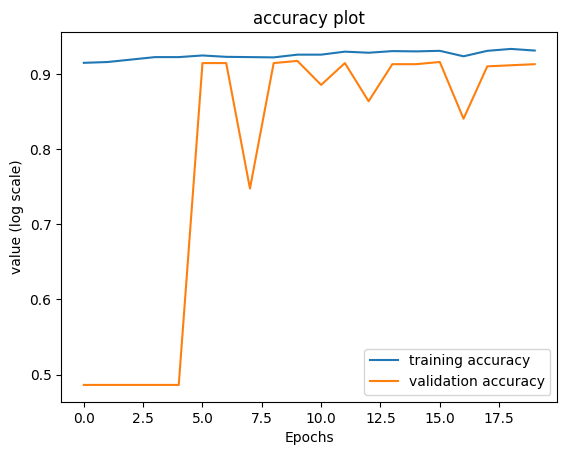

In [51]:
import matplotlib.pyplot as plt
plt.title('accuracy plot')
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

In [52]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'precision', 'recall', 'auc'])


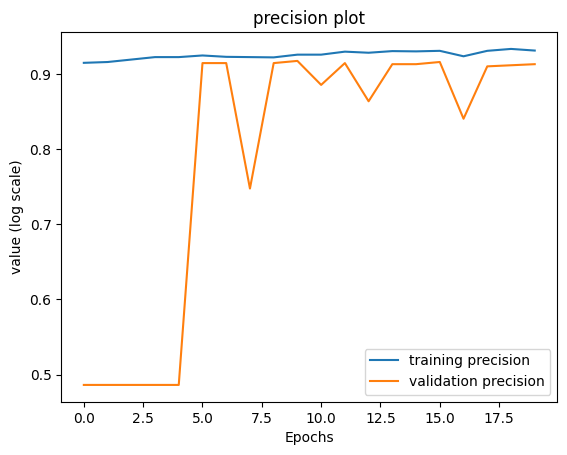

In [53]:
plt.title('precision plot')
plt.plot(history.history['precision'],label='training precision')
plt.plot(history.history['val_precision'],label='validation precision')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

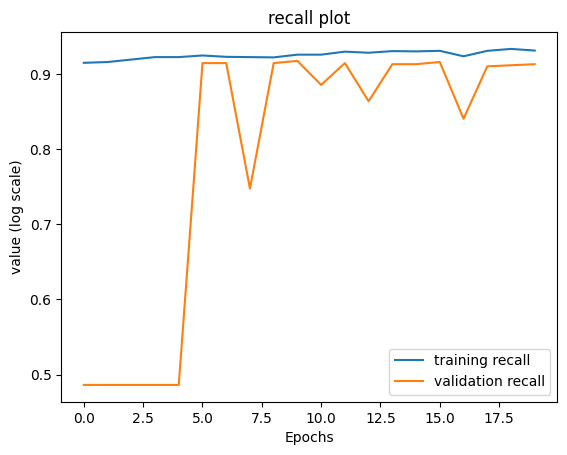

In [54]:
plt.title('recall plot')
plt.plot(history.history['recall'],label='training recall')
plt.plot(history.history['val_recall'],label='validation recall')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

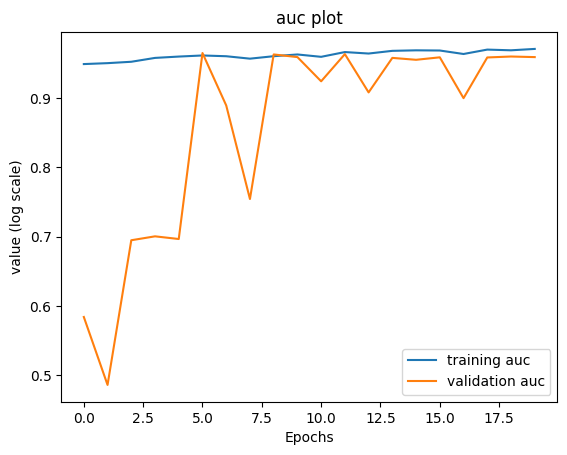

In [55]:
plt.title('auc plot')
plt.plot(history.history['auc'],label='training auc')
plt.plot(history.history['val_auc'],label='validation auc')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
train=model.predict(x_train)
val=model.predict(x_test)

 4/87 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step

W0000 00:00:1713111968.870095      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


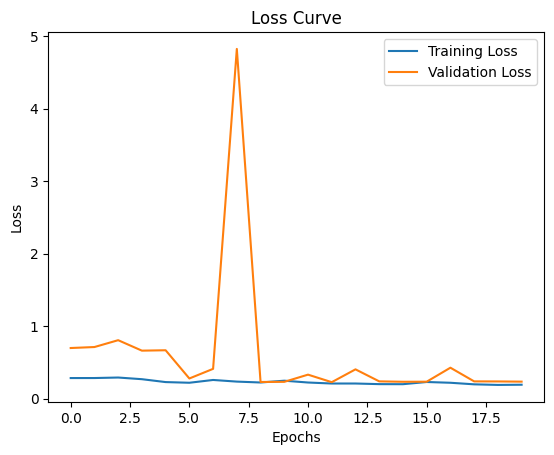

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Convert probabilities to binary predictions
train_predictions = (train >= 0.5).astype(int)
val_predictions = (val >= 0.5).astype(int)

# Plot confusion matrix for training data
plot_confusion_matrix(y_train, train_predictions, labels=['Negative', 'Positive'])

# Plot confusion matrix for validation data
plot_confusion_matrix(y_test, val_predictions, labels=['Negative', 'Positive'])


In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
train_predictions = (train >= 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix_train = confusion_matrix(y_train, train_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix_train, annot=True)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [60]:
sns.heatmap(confusion_matrix(val,y_test),annot=True)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [ ]:
print(classification_report(train,y_train))

In [ ]:
print(classification_report(val,y_test))